# PINN for Inverse Problem with the Viscous Burgers PDE

ECEN 689 Scientific Machine Learning - Spring 2022

Tensorflow 2.x implementation of PINN for estimating
viscosity in Burgers PDE with sinusoidal IC<br>

Author: Ulisses Braga-Neto <br>
Department of Electrical and Computer Engineering<br>
Texas A&M University<br>

This code demonstrates coding and training a physically-informed neural networks (PINN) to solve an inverse problem: finding the viscosity from data generated
by a Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\\
  \end{aligned}

where $\nu>0$ is the unknown kinematic viscosity. 

The data to train the PINN is generated by an accurate Gauss-Hermite quadrature of the Cole-Hopf formula for the exact solution. 

In [ ]:
# import necessary libraries

import tensorflow as tf
import numpy as np
import scipy.io
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
!pip -q install pyDOE
from pyDOE import lhs  # for latin hypercube sampling


In [ ]:
"""
Problem Definition and Quadrature Solution
"""

import numpy as np
from numpy.polynomial.hermite import hermgauss

nu = 0.01/np.pi # viscosity parameter

# define grid for quadrature solution
utn = 128
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 5.0/np.pi
ut = np.linspace (tlo,thi,utn)

qn = 64 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn])
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

# flatten grid and solution
X,T = np.meshgrid(ux,ut)
X_flat = tf.convert_to_tensor(np.hstack((X.flatten()[:,None],T.flatten()[:,None])),dtype=tf.float32)
u_flat = tf.convert_to_tensor(u_quad.T.flatten(),dtype=tf.float32)

In [ ]:
# solution neural network
def neural_net(layer_sizes):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(layer_sizes[0],)))
    for width in layer_sizes[1:-1]:
        model.add(layers.Dense(
            width, activation=tf.nn.tanh,
            kernel_initializer="glorot_normal"))
    model.add(layers.Dense(
            layer_sizes[-1], activation=None,
            kernel_initializer="glorot_normal"))
    return model

# PINN loss function
def loss(xcl,tcl,xs,ts,us,xlb,tlb,ulb,xub,tub,uub,param):
    u_pred  = u_PINN(tf.concat([xs,ts],1))
    ulb_pred = u_PINN(tf.concat([xlb,tlb],1))
    uub_pred = u_PINN(tf.concat([xub,tub],1))
    r_pred   = r_PINN(xcl,tcl,param)

    # loss components
    mse_s  = tf.reduce_mean(tf.pow(u_pred-us,2))
    mse_lb = tf.reduce_mean(tf.pow(ulb_pred-ulb,2))
    mse_ub = tf.reduce_mean(tf.pow(uub_pred-uub,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))
 
    return  mse_s+mse_r+mse_lb+mse_ub

# neural network weight gradients
@tf.function
def grad(model,xcl,tcl,xs,ts,us,xlb,tlb,ulb,xub,tub,uub,param):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,tcl,xs,ts,us,xlb,tlb,ulb,xub,tub,uub,param)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grad_param = tape.gradient(loss_value,param)
    return loss_value,grads,grad_param

In [ ]:
# data points
Ns = 10000
idxs = tf.range(tf.shape(X_flat)[0])
ridxs = tf.random.shuffle(idxs)[:Ns]
xs = tf.expand_dims(tf.gather(X_flat[:,0],ridxs),-1)
ts = tf.expand_dims(tf.gather(X_flat[:,1],ridxs),-1)
us = tf.expand_dims(tf.gather(u_flat,ridxs),-1)

# collocation points
Ncl = 10000
X = lhs(2,Ncl)
xcl = tf.expand_dims(tf.convert_to_tensor(xlo+(xhi-xlo)*X[:,0],dtype=tf.float32),-1)
tcl = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,1],dtype=tf.float32),-1)

# Dirichlet boundary condition points
Nlb = 500
X = lhs(1,Nlb)
tlb = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,0],dtype=tf.float32),-1)
xlb = xlo*tf.ones(tf.shape(tlb),dtype=tf.float32)
ulb = tf.zeros(tf.shape(tlb),dtype=tf.float32)
Nub = 500
X = lhs(1,Nub)
tub = tf.expand_dims(tf.convert_to_tensor(tlo+(thi-tlo)*X[:,0],dtype=tf.float32),-1)
xub = xlo*tf.ones(tf.shape(tub),dtype=tf.float32)
uub = tf.zeros(tf.shape(tub),dtype=tf.float32)

# test points for initial condition
N0 = 500
X = lhs(1,N0)
x0 = tf.expand_dims(tf.convert_to_tensor(xlo+(xhi-xlo)*X[:,0],dtype=tf.float32),-1)
t0 = tf.zeros(tf.shape(x0),dtype=tf.float32)
u0 = -tf.math.sin(np.pi*x0)

iter =  500
loss = 2.4708e-01
diffusion coefficient estimate = 0.0685/pi
L2 error for parameter: 5.8454e+00
L2 error for initial condition: 8.7791e-01
L2 error: 9.1407e-01


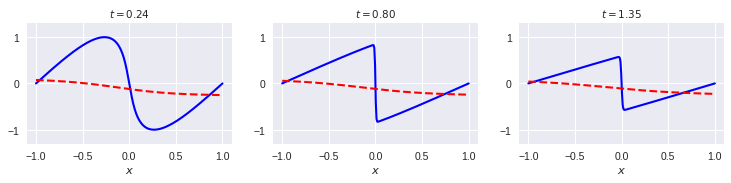

iter =  1000
loss = 1.9811e-01
diffusion coefficient estimate = 0.1153/pi
L2 error for parameter: 1.0535e+01
L2 error for initial condition: 7.7864e-01
L2 error: 8.1037e-01


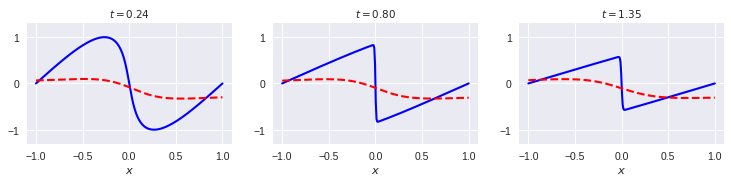

iter =  1500
loss = 1.0651e-01
diffusion coefficient estimate = 0.1010/pi
L2 error for parameter: 9.0967e+00
L2 error for initial condition: 5.9552e-01
L2 error: 5.3660e-01


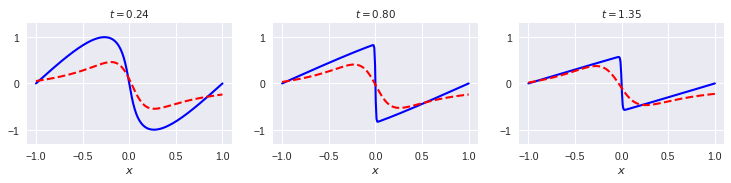

iter =  2000
loss = 7.1162e-02
diffusion coefficient estimate = 0.1357/pi
L2 error for parameter: 1.2566e+01
L2 error for initial condition: 4.4463e-01
L2 error: 4.2380e-01


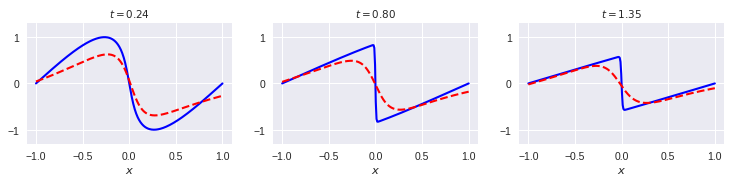

iter =  2500
loss = 4.4811e-02
diffusion coefficient estimate = 0.0896/pi
L2 error for parameter: 7.9634e+00
L2 error for initial condition: 4.0120e-01
L2 error: 3.4262e-01


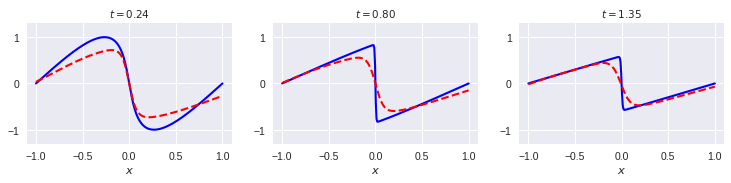

iter =  3000
loss = 3.1159e-02
diffusion coefficient estimate = 0.0703/pi
L2 error for parameter: 6.0316e+00
L2 error for initial condition: 3.8145e-01
L2 error: 2.8272e-01


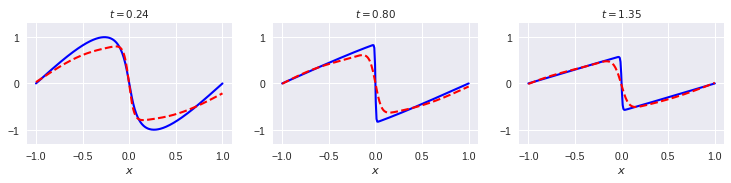

iter =  3500
loss = 2.5531e-02
diffusion coefficient estimate = 0.0658/pi
L2 error for parameter: 5.5839e+00
L2 error for initial condition: 3.9788e-01
L2 error: 2.6097e-01


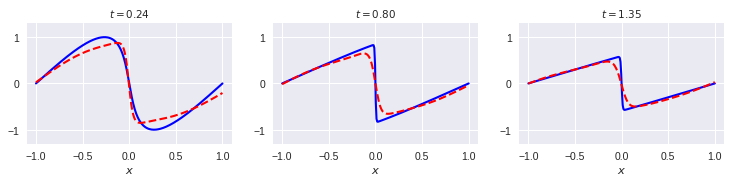

iter =  4000
loss = 2.2169e-02
diffusion coefficient estimate = 0.0570/pi
L2 error for parameter: 4.7039e+00
L2 error for initial condition: 4.0458e-01
L2 error: 2.4532e-01


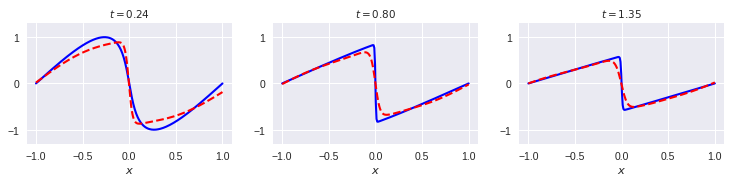

iter =  4500
loss = 1.9353e-02
diffusion coefficient estimate = 0.0465/pi
L2 error for parameter: 3.6497e+00
L2 error for initial condition: 4.0752e-01
L2 error: 2.2995e-01


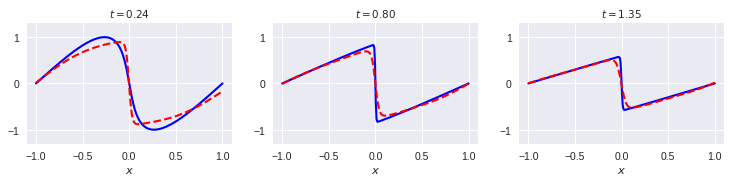

iter =  5000
loss = 1.7645e-02
diffusion coefficient estimate = 0.0398/pi
L2 error for parameter: 2.9835e+00
L2 error for initial condition: 3.9057e-01
L2 error: 2.1638e-01


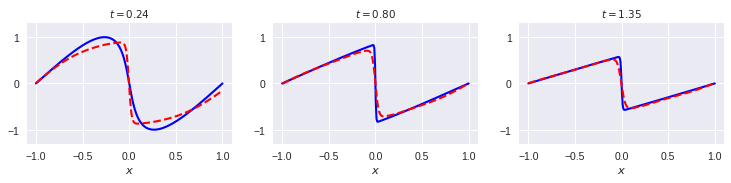

iter =  5500
loss = 1.5733e-02
diffusion coefficient estimate = 0.0360/pi
L2 error for parameter: 2.6012e+00
L2 error for initial condition: 3.5276e-01
L2 error: 2.0033e-01


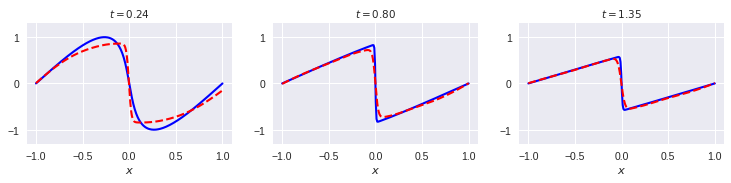

iter =  6000
loss = 1.2477e-02
diffusion coefficient estimate = 0.0331/pi
L2 error for parameter: 2.3118e+00
L2 error for initial condition: 2.8497e-01
L2 error: 1.7356e-01


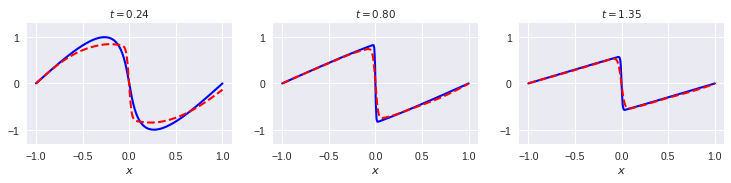

iter =  6500
loss = 8.7531e-03
diffusion coefficient estimate = 0.0315/pi
L2 error for parameter: 2.1531e+00
L2 error for initial condition: 1.9607e-01
L2 error: 1.3913e-01


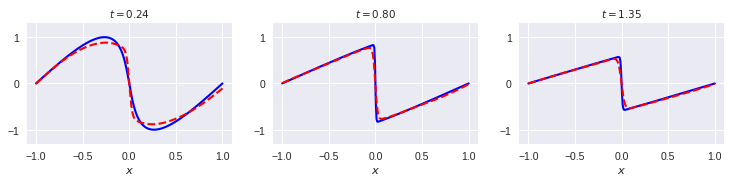

iter =  7000
loss = 6.5309e-03
diffusion coefficient estimate = 0.0284/pi
L2 error for parameter: 1.8437e+00
L2 error for initial condition: 1.5193e-01
L2 error: 1.1760e-01


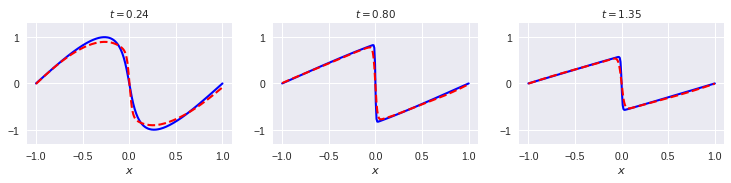

iter =  7500
loss = 4.8609e-03
diffusion coefficient estimate = 0.0249/pi
L2 error for parameter: 1.4854e+00
L2 error for initial condition: 1.2505e-01
L2 error: 9.9465e-02


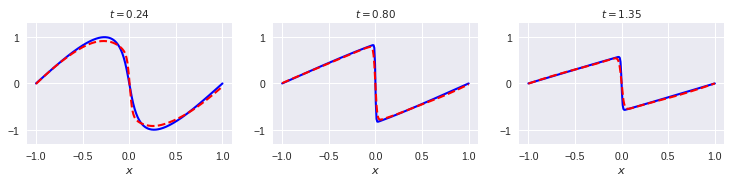

iter =  8000
loss = 3.6069e-03
diffusion coefficient estimate = 0.0227/pi
L2 error for parameter: 1.2657e+00
L2 error for initial condition: 1.0207e-01
L2 error: 8.4600e-02


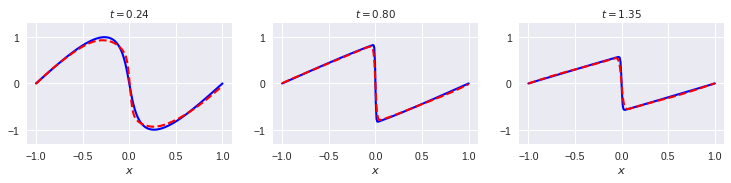

iter =  8500
loss = 2.6166e-03
diffusion coefficient estimate = 0.0215/pi
L2 error for parameter: 1.1460e+00
L2 error for initial condition: 7.8408e-02
L2 error: 7.1747e-02


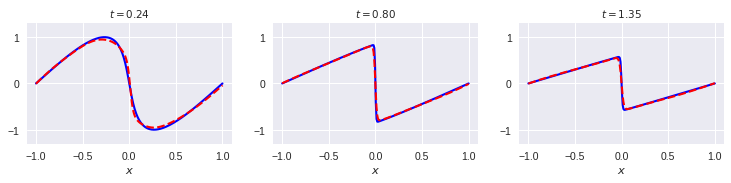

iter =  9000
loss = 1.9757e-03
diffusion coefficient estimate = 0.0202/pi
L2 error for parameter: 1.0186e+00
L2 error for initial condition: 6.3609e-02
L2 error: 6.2361e-02


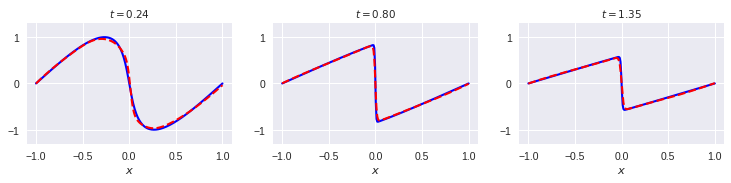

iter =  9500
loss = 1.5840e-03
diffusion coefficient estimate = 0.0188/pi
L2 error for parameter: 8.7880e-01
L2 error for initial condition: 5.5503e-02
L2 error: 5.5307e-02


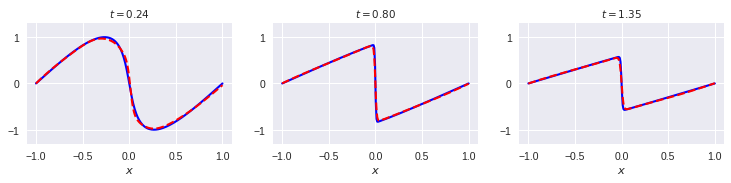

iter =  10000
loss = 1.3239e-03
diffusion coefficient estimate = 0.0176/pi
L2 error for parameter: 7.6219e-01
L2 error for initial condition: 5.0253e-02
L2 error: 4.9930e-02


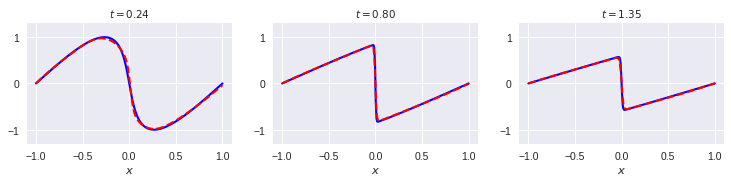

iter =  10500
loss = 1.1311e-03
diffusion coefficient estimate = 0.0167/pi
L2 error for parameter: 6.7238e-01
L2 error for initial condition: 4.6560e-02
L2 error: 4.5820e-02


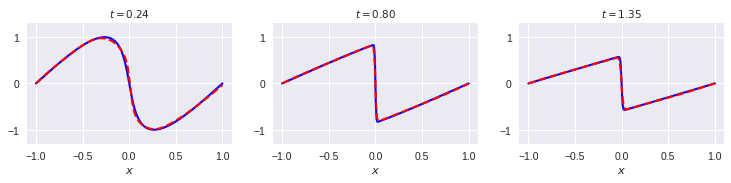

iter =  11000
loss = 9.8097e-04
diffusion coefficient estimate = 0.0160/pi
L2 error for parameter: 6.0055e-01
L2 error for initial condition: 4.3668e-02
L2 error: 4.2453e-02


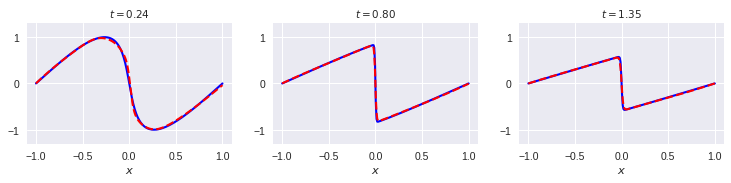

iter =  11500
loss = 8.5946e-04
diffusion coefficient estimate = 0.0154/pi
L2 error for parameter: 5.4052e-01
L2 error for initial condition: 4.1270e-02
L2 error: 3.9552e-02


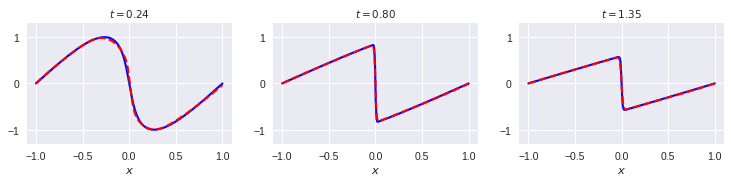

iter =  12000
loss = 7.6149e-04
diffusion coefficient estimate = 0.0149/pi
L2 error for parameter: 4.9126e-01
L2 error for initial condition: 3.9229e-02
L2 error: 3.6991e-02


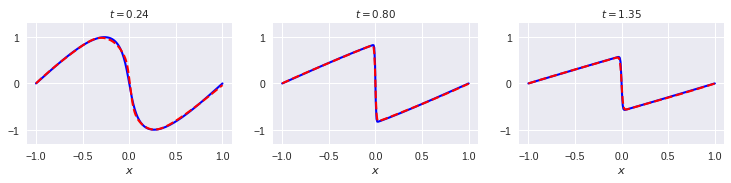

iter =  12500
loss = 6.8120e-04
diffusion coefficient estimate = 0.0145/pi
L2 error for parameter: 4.4575e-01
L2 error for initial condition: 3.7527e-02
L2 error: 3.4727e-02


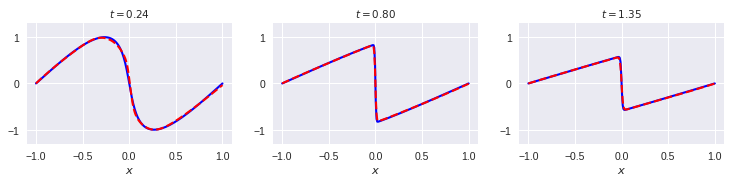

KeyboardInterrupt: ignored

In [ ]:
# training loop

# initialize new instance of NN
layer_sizes = [2] + 8*[20] + [1]
u_PINN = neural_net(layer_sizes)

# residual neural network
@tf.function
def r_PINN(x,t,param):
    u    = u_PINN(tf.concat([x,t], 1))
    u_x  = tf.gradients(u,x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_t  = tf.gradients(u,t)[0]
    return u_t + u*u_x - param*u_xx

# initialize parameter estimate
param = tf.Variable(0.1,trainable=True,dtype=tf.float32)

# Adam optimizer for neural network weights and parameter
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.99)
tf_optimizer_param = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.99)

# norm of high-fidelity approximation
norm_u = np.linalg.norm(u_flat,2)
norm_u0 = np.linalg.norm(u0,2)

for iter in range(20000):
  
  # compute gradients using AD
  loss_value,grads,grad_param = grad(u_PINN,xcl,tcl,xs,ts,us,xlb,tlb,ulb,xub,tub,uub,param)
    
  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads,u_PINN.trainable_variables))  

  # update parameter estimate
  tf_optimizer_param.apply_gradients(zip([grad_param],[param]))

  # display intermediate results  
  if ((iter+1) % 500 == 0):
    print('iter =  '+str(iter+1))
    print('loss = %.4e' % loss_value)
    print('diffusion coefficient estimate = {:.4f}/pi'.format(np.pi*param.numpy()))
    print('L2 error for parameter: %.4e' % (np.abs(param-nu)/nu))
    u0_pred = u_PINN(tf.concat([x0,t0],1))
    err0 = np.linalg.norm(u0-u0_pred,2)/norm_u0
    print('L2 error for initial condition: %.4e' % (err0))
    u_PINN_flat = u_PINN(X_flat)
    err = np.linalg.norm(u_flat-u_PINN_flat[:,-1],2)/norm_u
    print('L2 error: %.4e' % (err))
    #plot_slices(u_flat,u_PINN_flat,[0.15,0.5,0.85])
    fig = plt.figure(figsize=(12,4),dpi=75)
    plt.style.use('seaborn')
    for gi,snap in enumerate([0.15,0.5,0.85]):
      tind = int(snap*len(ut))
      ax = fig.add_subplot(1,3,gi+1)
      ax.set_aspect(0.5)
      ax.plot(ux,u_flat[tind*uxn:(tind+1)*uxn],'b-',linewidth=2,label='Exact')       
      ax.plot(ux,u_PINN_flat[tind*uxn:(tind+1)*uxn,0],'r--',linewidth=2,label='Prediction')
      ax.set_title('$t = %.2f$' % (ut[tind]),fontsize=10)
      ax.set_xlabel('$x$')
      ax.set_ylim([-1.3,1.3])
    plt.show()

In [ ]:
#Display results

fig = plt.figure(figsize=(14,6),dpi=75)
fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(121)
ax.set_aspect(1)
im=ax.imshow(np.reshape(u_flat,(utn,uxn)).T,interpolation='nearest',cmap='seismic',extent=[0.0,1.0,0.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(122)
ax.set_aspect(1)
im=ax.imshow(np.reshape(u_PINN_flat,(utn,uxn)).T,interpolation='nearest',cmap='seismic',extent=[0.0,1.0,0.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('PINN Prediction (L2 error = {:.4f})'.format(err),fontsize=16)